**Authors : Akeniouene**

À travers ce notebook nous allons voir comment les GNNs fonctionnent et comment les applique-t-on pour de la classification de noeuds, à l'aide de la librairie `PyG` sous `PyTorch`.
Une comparaison sera faite avec un simple perceptron multicouches (MLP).



Nous disposons dans ce probleme d'un certain nombre de noeuds étiquetés, et nous voulons déduire les étiquettes restantes.
Nous utiliserons le dataset `Cora`, qui est un réseau de citation où les nœuds représentent des documents.
- Chaque noeud est décrit par un **Bag of words vector**.
- IL existe un arc entre deux noeuds, ssi, il existe une citation d'un des documents vers l'autre.
- Le but de classifier tout document suivant les 7 classes existantes.


In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
%matplotlib inline

**Data description**

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print('Comme on peut le voir, notre dataset dispose de:')
print(dataset.num_features,'features')
print(dataset.num_classes,'classes')

data = dataset[0]  # Get the first graph object.


print(data.num_nodes,'noeuds')
print(data.num_edges ,'arêtes')

print(int(data.train_mask.sum()), 'noeuds de train')
print('Graphe non dirigé :',data.is_undirected())

Comme on peut le voir, notre dataset dispose de:
1433 features
7 classes
2708 noeuds
10556 arêtes
140 noeuds de train
Graphe non dirigé : True


Ce graph dispose également de `val_mask` et `test_mask`, qui désignent les noeuds pour la phase de validation puis de test réspectivement.

Notre dataset est normalisé en faisant appel à la méthode `NormalizeFeatures` de `torch_geometric.transforms`.

## Partie MLP

Dans cette partie nous allons voir comment ce débrouille un perceptron multicouches sur notre probleme semi-supervisé.

Évidement, notre MLP ne prendra pas en compte le voisinages d'un noeud comme attribut, mais uniquement le noeud lui même et ainsi déduire sa catégorie selon ses caracteristiques propres.


In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F



class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Notre MLP est défini

Notre MLP est défini par deux couches linéaires puis une fonction d'activation  par la non-linéarité `ReLU` et `dropout`.

In [4]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  

def train():
      model.train()
      optimizer.zero_grad()  
      out = model(data.x)
      # Nous calculons la loss uniquement avec les noeuds de train
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward()  
      optimizer.step()
      return loss.item()

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Calcul de accuracy 
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
          print(f'Epoch: {epoch:3d}, Loss: {loss:.4f}')

Epoch:  20, Loss: 1.7441
Epoch:  40, Loss: 1.2543
Epoch:  60, Loss: 0.8578
Epoch:  80, Loss: 0.6368
Epoch: 100, Loss: 0.5350
Epoch: 120, Loss: 0.4745
Epoch: 140, Loss: 0.4031
Epoch: 160, Loss: 0.3782
Epoch: 180, Loss: 0.4203
Epoch: 200, Loss: 0.3810


Testons à présent la qualité de notre MLP après l'avoir entrainé.

In [5]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


On peut voir que les résultats ne sont pas satisfaisants.

Cela pourrait s'expliquer par le fait que l'on dispose de peu de noeuds de train.

## Partie GNN
 Une couche **GCN** est définie par:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

$\mathbf{W}^{(\ell + 1)}$ définie une matrice de poids de dimensions `[num_output_features, num_input_features]` et $c_{w,v}$ est un coéficient de normalisation pour chaque arête.

De l'autre coté, nous avons la définition d'une couche linéaire qui ne fait pas appel aux données qui peuvent êtres aquisent de le voisinage:

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$



In [6]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)



Nous pouvons visualiser avant entrainement la représentation des données en réduisant les dimensions à 2 à l'aide de TSNEE.

TSNEE qui joue le même rôle que PCA, la réduction de dimensions.

/home/akaen/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/akaen/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


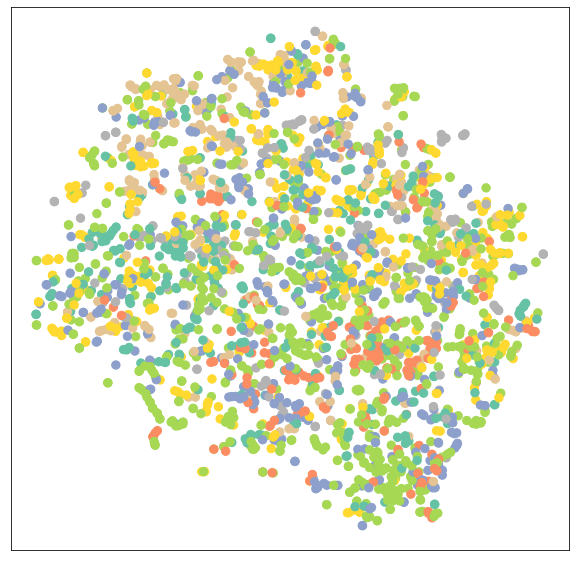

In [7]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

#### Train / Test

In [8]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      #cette fois-ci on rajoute les edge_index
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
          print(f'Epoch: {epoch:3d}, Loss: {loss:.4f}')

Epoch:  20, Loss: 1.7310
Epoch:  40, Loss: 1.3258
Epoch:  60, Loss: 0.9741
Epoch:  80, Loss: 0.6755
Epoch: 100, Loss: 0.5799
Epoch: 120, Loss: 0.4883
Epoch: 140, Loss: 0.3921
Epoch: 160, Loss: 0.3510
Epoch: 180, Loss: 0.3497
Epoch: 200, Loss: 0.3045


In [9]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8020


Cette fois-ci nous atteignons les 80% d'accuracy, ce qui augmonte de beaucoup le score atteint avec notre MLP basique.

/home/akaen/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/akaen/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


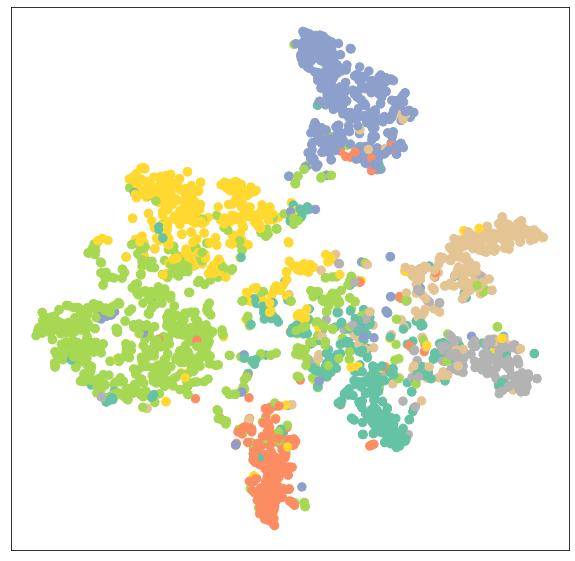

In [10]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

On peut clairement voir la formation des 7 clusters.

Comme vu en TP, on suppose que la qualité du modèle augmente avec l'augmentation du nombre de noeuds connus utilisés dans la phase de train.